In [5]:
import os, sys, time
import pandas as pd
import numpy as np
import lightgbm as lgb
import gc

In [42]:
import sklearn
from sklearn.preprocessing import Imputer, MinMaxScaler
from sklearn.model_selection import train_test_split

In [7]:
pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows',None)
pd.set_option('display.max_colwidth', -1)

In [9]:
WIDS = ('/').join(os.getcwd().split('/')[:-2])
DATA = os.path.join(WIDS,'DATA')

In [210]:
train = pd.read_csv(os.path.join(DATA,'TrainingWiDS2021.csv'))
test = pd.read_csv(os.path.join(DATA,'UnlabeledWiDS2021.csv'))
datadictionary = pd.read_csv(os.path.join(DATA,'DataDictionaryWiDS2021.csv'))

In [211]:
datadictionary.head()

,Category,Variable Name,Unit of Measure,Data Type,Description,Example
0,identifier,encounter_id,None,integer,Unique identifier associated with a patient unit stay,None
1,identifier,hospital_id,None,integer,Unique identifier associated with a hospital,None
2,demographic,age,Years,numeric,The age of the patient on unit admission,None
3,demographic,bmi,kilograms/metres^2,string,The body mass index of the person on unit admission,21.5
4,demographic,elective_surgery,None,binary,Whether the patient was admitted to the hospital for an elective surgical operation,0


In [212]:
train.drop(columns='Unnamed: 0',inplace=True)
test.drop(columns='Unnamed: 0',inplace=True)

In [213]:
train.shape, test.shape

((130157, 180), (10234, 179))

In [266]:
# train.head()

# To analyze variables on broad scale

In [215]:
#Target variable
ones = train['diabetes_mellitus'].value_counts()[1]
zeros = train['diabetes_mellitus'].value_counts()[0]
print(" We have {}% of diabetes in the training population".format(round(ones*100/zeros,2)))

 We have 27.6% of diabetes in the training population


In [216]:
train['ethnicity'].value_counts()

Caucasian           100236
African American    13911 
Other/Unknown       6261  
Hispanic            5049  
Asian               2198  
Native American     915   
Name: ethnicity, dtype: int64

In [217]:
continuous_cols = ['age',
'bmi',
'gender',
'height',
'weight',
'pre_icu_los_days',
'heart_rate_apache']
binary_cols = ['elective_surgery',
    'apache_post_operative',
'arf_apache',
'aids',
'cirrhosis',
'hepatic_failure',
'immunosuppression',
'leukemia',
'lymphoma',
'solid_tumor_with_metastasis']

cat_cols = ['ethnicity',
           'icu_type']

In [218]:
train[all_cols].isnull().sum(), len(train)

(age                            4988
 bmi                            4490
 gender                         66  
 height                         2077
 weight                         3463
 pre_icu_los_days               0   
 heart_rate_apache              309 
 elective_surgery               0   
 apache_post_operative          0   
 arf_apache                     0   
 aids                           0   
 cirrhosis                      0   
 hepatic_failure                0   
 immunosuppression              0   
 leukemia                       0   
 lymphoma                       0   
 solid_tumor_with_metastasis    0   
 ethnicity                      1587
 icu_type                       0   
 dtype: int64, 130157)

In [219]:
test[all_cols].isnull().sum(), len(test)

(age                            0   
 bmi                            1015
 gender                         5   
 height                         301 
 weight                         908 
 pre_icu_los_days               0   
 heart_rate_apache              30  
 elective_surgery               0   
 apache_post_operative          0   
 arf_apache                     0   
 aids                           0   
 cirrhosis                      0   
 hepatic_failure                0   
 immunosuppression              0   
 leukemia                       0   
 lymphoma                       0   
 solid_tumor_with_metastasis    0   
 ethnicity                      204 
 icu_type                       0   
 dtype: int64, 10234)

# To correct values in continuous cols

In [220]:
# To convert gender
train['gender'] = train['gender'].apply(lambda x: 1 if x=='F' else 0)
test['gender'] = test['gender'].apply(lambda x: 1 if x=='F' else 0)

In [221]:
# To impute values for continuous cols
impute = Imputer()
scaler = MinMaxScaler()

In [222]:
x_train_cont1 = impute.fit_transform(train[continuous_cols])
x_train_cont = scaler.fit_transform(x_train_cont1)

x_test_cont1 = impute.fit_transform(test[continuous_cols])
x_test_cont = scaler.fit_transform(x_test_cont1)

In [223]:
x_train_cont_df = pd.DataFrame(x_train_cont,columns=continuous_cols)
x_test_cont_df = pd.DataFrame(x_test_cont,columns=continuous_cols)

In [232]:
x_test_cont.shape, x_test_cont_df.shape

((10234, 7), (10234, 7))

In [225]:
x_train_cont_df.head()

,age,bmi,gender,height,weight,pre_icu_los_days,heart_rate_apache
0,0.764045,0.148912,0.0,0.738140,0.239484,0.004501,0.594595
1,0.865169,0.237435,1.0,0.390478,0.214383,0.006697,0.608108
2,0.280899,0.322972,1.0,0.607981,0.384668,0.001425,0.486486
3,0.910112,0.147076,1.0,0.477822,0.156716,0.001425,0.567568
4,0.213483,0.269309,0.0,0.870012,0.306588,0.001840,0.202703


In [226]:
x_train_cont_df.isnull().sum()

age                  0
bmi                  0
gender               0
height               0
weight               0
pre_icu_los_days     0
heart_rate_apache    0
dtype: int64

In [227]:
# To get binary cols
x_train_binary_df = train[binary_cols]
x_test_binary_df = test[binary_cols]

In [228]:
# To get the target col
y_train_df = train['diabetes_mellitus']

In [229]:
# To prepare the categorical columns
train[cat_cols] = train[cat_cols].fillna(value='Other/Unknown')
test[cat_cols] = test[cat_cols].fillna(value='Other/Unknown')

In [230]:
x_train_cat = pd.get_dummies(train[cat_cols],prefix=cat_cols)
x_test_cat = pd.get_dummies(test[cat_cols],prefix=cat_cols)

In [236]:
x_test_cat_df.shape, x_test_cont_df.shape, x_test_binary_df.shape, x_test_cont_cat.shape, x_test_cont_cat_bin.shape

((10234, 14), (10234, 7), (10234, 10), (10234, 21), (10234, 31))

In [233]:
x_train_cat_cols = x_train_cat.columns.tolist()
x_test_cat_cols = x_test_cat.columns.tolist()

In [234]:
x_train_cat_df = pd.DataFrame(x_train_cat,columns=x_train_cat_cols)
x_test_cat_df = pd.DataFrame(x_test_cat,columns=x_test_cat_cols)

In [237]:
x_train_cont_cat = pd.concat([x_train_cont_df,x_train_cat_df],sort=False,axis=1)
x_train_cont_cat_bin = pd.concat([x_train_cont_cat,x_train_binary_df],sort=False,axis=1)

x_test_cont_cat = pd.concat([x_test_cont_df,x_test_cat_df],sort=False,axis=1)
x_test_cont_cat_bin = pd.concat([x_test_cont_cat,x_test_binary_df],sort=False,axis=1)

In [238]:
x_train1, x_valid, y_train1,y_valid = train_test_split(x_train_cont_cat,
                                                     y_train_df,
                                                     test_size=0.33,stratify=y_train_df)

In [239]:
x_train, x_test, y_train,y_test = train_test_split(x_train1,
                                                     y_train1,
                                                     test_size=0.33,stratify=y_train1)

In [240]:
x_train.head()

,age,bmi,gender,height,weight,pre_icu_los_days,heart_rate_apache,ethnicity_African American,ethnicity_Asian,ethnicity_Caucasian,ethnicity_Hispanic,ethnicity_Native American,ethnicity_Other/Unknown,icu_type_CCU-CTICU,icu_type_CSICU,icu_type_CTICU,icu_type_Cardiac ICU,icu_type_MICU,icu_type_Med-Surg ICU,icu_type_Neuro ICU,icu_type_SICU
47623,0.696574,0.248081,0.0,0.433293,0.239484,0.001879,0.648649,0,0,1,0,0,0,0,0,0,0,0,1,0,0
57577,0.775281,0.310665,1.0,0.477822,0.316961,0.003360,0.168919,0,0,1,0,0,0,1,0,0,0,0,0,0,0
123637,0.831461,0.255453,0.0,0.681624,0.341248,0.003502,0.074324,0,0,1,0,0,0,0,0,0,0,0,1,0,0
16852,0.719101,0.179452,1.0,0.520637,0.202171,0.001951,0.628378,0,0,1,0,0,0,0,0,0,0,0,1,0,0
21110,0.943820,0.205239,0.0,0.607981,0.258480,0.007530,0.432432,0,0,1,0,0,0,0,1,0,0,0,0,0,0


In [241]:
model_data = pd.concat([x_train,y_train],axis=1)

In [242]:
model_1 = model_data[model_data['diabetes_mellitus']==1]
model_0 = model_data[model_data['diabetes_mellitus']==0]
len(model_1),len(model_0)

(12637, 45790)

# To undersample the training data

In [243]:
model_0_new = model_0.sample(len(model_1))

In [244]:
model_data_new = pd.concat([model_1,model_0_new])
model_data_new_shuffled = model_data_new.sample(len(model_data_new))

In [245]:
model_data_new_shuffled.shape

(25274, 22)

In [246]:
x_train_new = model_data_new_shuffled.loc[:, model_data_new_shuffled.columns != 'diabetes_mellitus']
y_train_new = model_data_new_shuffled['diabetes_mellitus']

In [247]:
x_train_new.head()

,age,bmi,gender,height,weight,pre_icu_los_days,heart_rate_apache,ethnicity_African American,ethnicity_Asian,ethnicity_Caucasian,ethnicity_Hispanic,ethnicity_Native American,ethnicity_Other/Unknown,icu_type_CCU-CTICU,icu_type_CSICU,icu_type_CTICU,icu_type_Cardiac ICU,icu_type_MICU,icu_type_Med-Surg ICU,icu_type_Neuro ICU,icu_type_SICU
26057,0.662921,0.220642,0.0,0.825484,0.356852,0.009725,0.121622,0,0,1,0,0,0,0,1,0,0,0,0,0,0
19452,0.629213,0.180656,0.0,0.912828,0.339213,0.001421,0.445946,0,0,1,0,0,0,0,0,0,0,0,1,0,0
37331,0.662921,0.096951,0.0,0.652509,0.154681,0.002065,0.554054,0,0,0,0,0,1,0,0,0,0,1,0,0,0
108801,0.550562,0.133450,0.0,0.818633,0.246947,0.002128,0.452703,0,0,0,0,0,1,0,0,0,0,1,0,0,0
68247,0.584270,0.180548,0.0,0.825484,0.307327,0.002499,0.547297,0,0,1,0,0,0,0,0,0,0,0,1,0,0


In [248]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score, roc_curve, recall_score,  precision_recall_curve
import importlib
from itertools import *

In [250]:
# classifier = LogisticRegression(C=0.1, solver='saga', penalty='l1')
# cv_score = np.mean(cross_val_score(classifier, x_train_new, y_train_new, cv=5,n_jobs = -1, scoring='roc_auc'))
# print(cv_score)

In [251]:
model = classifier.fit(x_train_new, y_train_new)

In [252]:
y_pred = model.predict(x_test)

In [253]:
roc_per_class = roc_auc_score(y_test, y_pred)
roc_per_class

0.6096552008398922

In [254]:
lgb_train = lgb.Dataset(x_train_new, y_train_new)
lgb_eval = lgb.Dataset(x_valid, y_valid, reference=lgb_train)

In [255]:
params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': {'l1', 'auc'},
    'num_leaves': 500,
    'learning_rate': 0.001,
    'bagging_fraction': 0.8,
    'importance_type':'split',
    'reg_alpha':1.3,
    'reg_lambda':0.1,
    'bagging_freq': 5,
    'scale_pos_weight':9.0, # because training data is unbalanced 
    'verbose': 0
}

In [256]:
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=1000,
                valid_sets=lgb_eval,
                early_stopping_rounds=250,
                verbose_eval=50)
y_pred = gbm.predict(x_test, num_iteration=gbm.best_iteration)
print('Prediction done...')

Training until validation scores don't improve for 250 rounds.
[50]	valid_0's l1: 0.509114	valid_0's auc: 0.657053
[100]	valid_0's l1: 0.517725	valid_0's auc: 0.658172
[150]	valid_0's l1: 0.525857	valid_0's auc: 0.658858
[200]	valid_0's l1: 0.533551	valid_0's auc: 0.659355
[250]	valid_0's l1: 0.54083	valid_0's auc: 0.65956
Early stopping, best iteration is:
[1]	valid_0's l1: 0.500186	valid_0's auc: 0.645692
Prediction done...


In [257]:
results = gbm.predict(x_test_cont_cat_bin, num_iteration=gbm.best_iteration)

In [258]:
len(results)

10234

In [259]:
roc_per_class = roc_auc_score(y_test, y_pred)
roc_per_class

0.6458520366601446

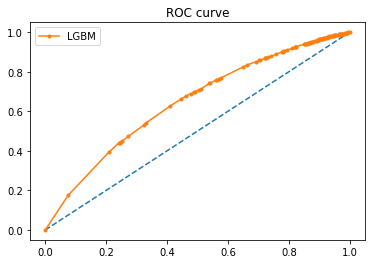

In [260]:
fpr, tpr, _ = roc_curve(y_test,y_pred)
from matplotlib import pyplot
pyplot.plot([0, 1], [0, 1], linestyle='--')
pyplot.plot(fpr, tpr, marker='.', label = 'LGBM')
pyplot.legend(loc='best')
pyplot.title('ROC curve')
pyplot.show()

# We could have this as a simple handpicked columns for a baseline model which is clearly underfitted

Still things to do could be 
1. Impute missing values with more EDA
2. Find and remove highly correlated variables
3. Include more variables based on their 

In [262]:
enc_id = test['encounter_id'].values.tolist()
len(enc_id)

10234

In [263]:
SampleSubmission = pd.DataFrame({'encounter_id':enc_id,
                                'diabetes_mellitus':results})

In [265]:
SampleSubmission.to_csv(os.path.join(DATA,'Submission_1.csv'),index=False)